In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tensorflow import keras


In [3]:
data = pd.read_csv("river_data.csv")

data['SensorTime']= pd.to_datetime(data['SensorTime'])
data.head()


,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,width,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train = pd.read_csv("./data/train_data.csv")
test = pd.read_csv("./data/test_data.csv")
validation = pd.read_csv("./data/validation_data.csv")

Found 25235 validated image filenames.
Found 12618 validated image filenames.
Found 4206 validated image filenames.


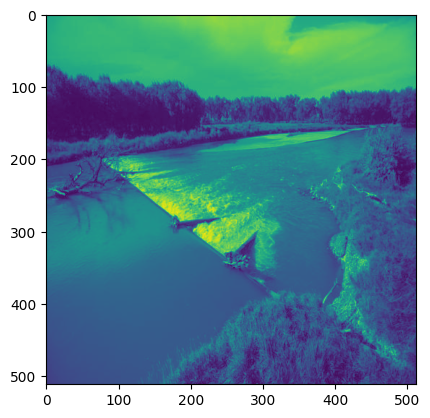

In [6]:
labels_train = train[[" Filename", " Stage"]]
labels_test = test[[" Filename", " Stage"]]
labels_validation = validation[[" Filename", " Stage"]]
generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

train_generator=generator.flow_from_dataframe(
    dataframe=labels_train,
    directory="./data/images/train",
    x_col=" Filename",
    y_col=" Stage",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode="grayscale",
    target_size=(512,512))

test_generator = generator.flow_from_dataframe(
    dataframe=labels_test,
    directory="./data/images/test",
    x_col=" Filename",
    y_col=" Stage",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode="grayscale",
    target_size=(512,512))

validation_generator = generator.flow_from_dataframe(
    dataframe=labels_validation,
    directory="./data/images/validation",
    x_col=" Filename",
    y_col=" Stage",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode="grayscale",
    target_size=(512,512))

plt.imshow(validation_generator[0][0][0])



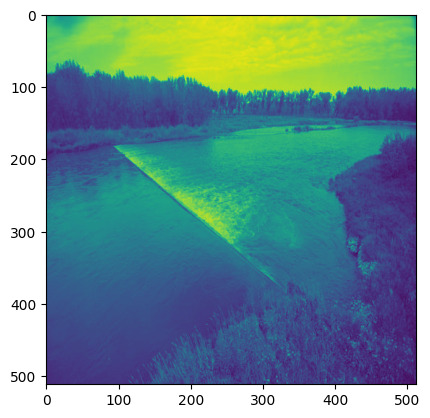

In [7]:
plt.imshow(test_generator[0][0][0])


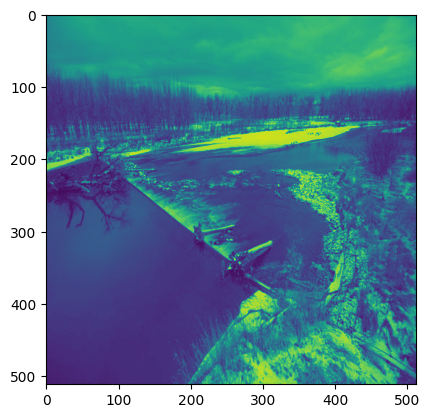

In [8]:
plt.imshow(train_generator[0][0][0])


In [11]:
inputs = keras.Input(shape=(512, 512, 1))
x = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

In [12]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='mse'
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=7,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/7


2022-11-15 13:17:15.042719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


789/789 [==============================] - ETA: 0s - loss: 0.9317

2022-11-15 13:19:23.270524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


789/789 [==============================] - 139s 174ms/step - loss: 0.9317 - val_loss: 0.6218
Epoch 2/7
789/789 [==============================] - 135s 172ms/step - loss: 0.6300 - val_loss: 0.5961
Epoch 3/7
789/789 [==============================] - 136s 173ms/step - loss: 0.5827 - val_loss: 0.5215
Epoch 4/7
789/789 [==============================] - 135s 171ms/step - loss: 0.5169 - val_loss: 0.4689
Epoch 5/7
789/789 [==============================] - 135s 171ms/step - loss: 0.4620 - val_loss: 0.4591
Epoch 6/7
789/789 [==============================] - 135s 172ms/step - loss: 0.4265 - val_loss: 0.4172
Epoch 7/7
789/789 [==============================] - 135s 171ms/step - loss: 0.3986 - val_loss: 0.3651


In [13]:

rmse = np.sqrt(model.evaluate(test_generator, verbose=0))
print("Test RMSE: ",rmse)


Test RMSE:  0.605851280212435
